In [1]:
import random
import time
import pickle
import sys
import json
import re
import string
import collections
import codecs
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

#sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
#sudo pip install pygraphviz
import pygraphviz 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

## 1 - Fragebogen

#### Reading fragebogen information

In [2]:
fb_original = pd.read_pickle('./fb_original.pickle')

In [3]:
fb_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 1 to 109
Data columns (total 5 columns):
titel                   109 non-null object
fragebogen_num          109 non-null object
fragebogen_headwords    109 non-null object
fragebogen_series       109 non-null object
headwords_list          109 non-null object
dtypes: object(5)
memory usage: 5.1+ KB


In [4]:
fb_original.head(10)

titel fragebogen_num  \
nummer                                                                     
1                                  Fragebogen 1: Kopf (1)              1   
2                        Fragebogen 2: Die Osterwoche (1)              2   
3                        Fragebogen 3: Die Osterwoche (2)              3   
4                                  Fragebogen 4: Kopf (2)              4   
5       Fragebogen 5: Zeit zwischen Ostern und Fronlei...              5   
6         Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)              6   
7                              Fragebogen 7: Hochzeit (1)              7   
8                              Fragebogen 8: Hochzeit (2)              8   
9                              Fragebogen 9: Hochzeit (3)              9   
10                            Fragebogen 10: Hochzeit (4)             10   

                         fragebogen_headwords fragebogen_series  \
nummer                                                            
1                                        Kopf               (1)   
2                              Die Osterwoche               (1)   
3                              Die Osterwoche               (2)   
4                                        Kopf               (2)   
5       Zeit zwischen Ostern und Fronleichnam                     
6                      Menschl. Haar und Bart        (= Kopf 3)   
7                                    Hochzeit               (1)   
8                                    Hochzeit               (2)   
9                                    Hochzeit               (3)   
10                                   Hochzeit               (4)   

                      headwords_list  
nummer                                
1                             [kopf]  
2                       [osterwoche]  
3                       [osterwoche]  
4                             [kopf]  
5       [fronleichnam, zeit, ostern]  
6              [haar, menschl, bart]  
7                         [hochzeit]  
8                         [hochzeit]  
9                         [hochzeit]  
10                        [hochzeit]

In [5]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.fragebogen_num:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'fragebogen_num'], length = 10)

In [6]:
#print(G.nodes)
print(G.edges)

[('kopf', '1'), ('kopf', '4'), ('osterwoche', '2'), ('osterwoche', '3'), ('fronleichnam', '5'), ('zeit', '5'), ('zeit', '54'), ('zeit', '68'), ('zeit', '72'), ('ostern', '5'), ('ostern', '72'), ('haar', '6'), ('menschl', '6'), ('bart', '6'), ('hochzeit', '7'), ('hochzeit', '8'), ('hochzeit', '9'), ('hochzeit', '10'), ('hochzeit', '11'), ('ohr', '12'), ('nase', '12'), ('auge', '13'), ('flur', '14'), ('flur', '15'), ('besiedelung', '14'), ('besiedelung', '15'), ('feldbestellung', '16'), ('feldbestellung', '17'), ('feldbestellung', '18'), ('feldbestellung', '19'), ('feld', '16'), ('feld', '17'), ('feld', '18'), ('feld', '19'), ('körper', '20'), ('körper', '21'), ('körper', '22'), ('körper', '23'), ('körperteil', '24'), ('körperteil', '77'), ('körperteil', '78'), ('hautkrankheit', '25'), ('hautkrankheit', '26'), ('hautkrankheit', '27'), ('brotbacken', '28'), ('brotbacken', '29'), ('brotbacken', '30'), ('weißgebäck', '31'), ('arm', '32'), ('arm', '33'), ('gliedmaß', '32'), ('hand', '34'), (

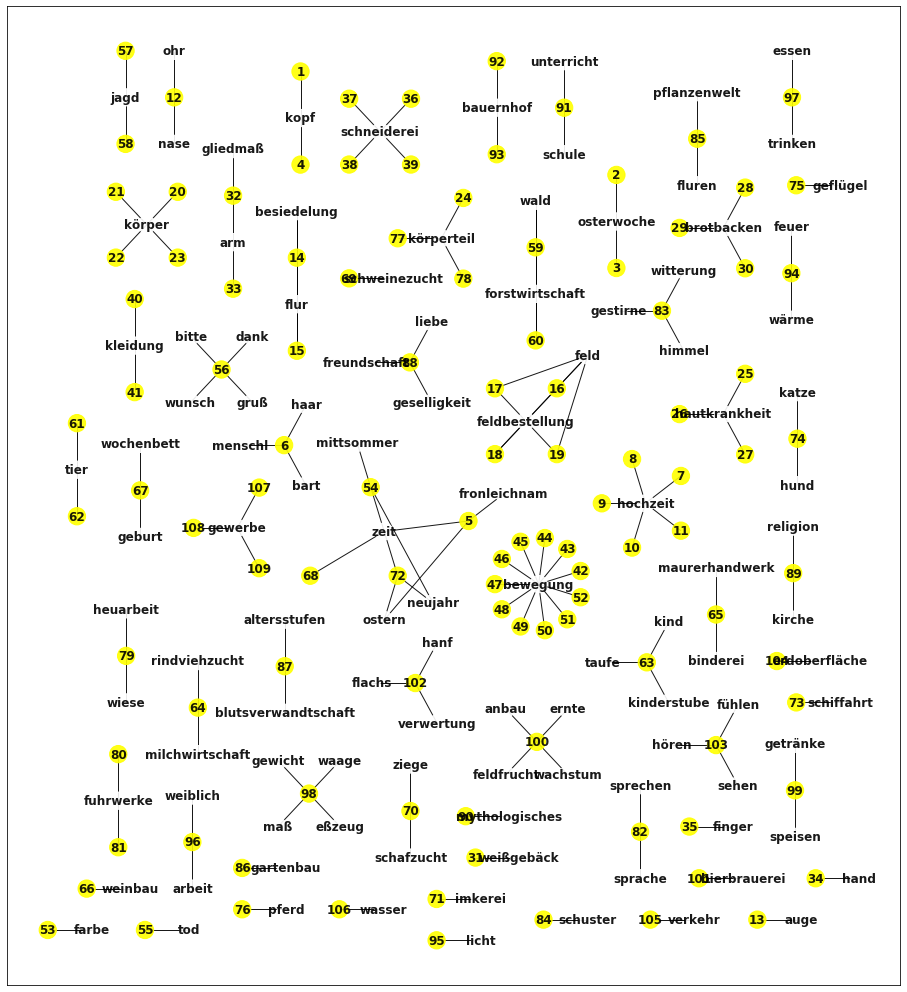

In [7]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph
#if Win: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# https://stackoverflow.com/questions/4571067/installing-pygraphviz-on-windows?rq=1
#if Anaconda: conda install graphviz pygraphviz -c alubbock
#pip install --global-option=build_ext --global-option="-IC:\Program Files\<path>\Graphviz2.38\include" --global-option="-LC:\Program Files\Graphviz2.38\lib\release\lib" pygraphviz

plt.figure(figsize=(16,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 #width=5,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 font_weight='bold', 
                 #font_color='white',
                 )


#plt.show()
plt.savefig('./outputs/fragebogen.png', bbox_inches='tight')

## 2 - Frage

#### Reading frage information

In [8]:
frage = pd.read_pickle('./frage.pickle')

In [9]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16738 entries, 0 to 16743
Data columns (total 12 columns):
id                 16738 non-null int64
fragebogen_num     16738 non-null int64
frage_num          16738 non-null object
original_frage     16738 non-null object
kurzfrage          16738 non-null object
main_theme         16722 non-null object
question_words     16738 non-null object
semantic_words     16738 non-null object
syntactic_words    5598 non-null object
NN                 16649 non-null object
VB                 5930 non-null object
ADJ                6712 non-null object
dtypes: int64(2), object(10)
memory usage: 1.7+ MB


In [10]:
frage.head(10)

id  fragebogen_num frage_num  \
0   1               1        A1   
1   2               1        A2   
2   3               1        A3   
3   4               1        A4   
4   5               1       A4a   
5   6               1        A5   
6   7               1       A5a   
7   8               1        A6   
8   9               1        A7   
9  10               1        A8   

                                      original_frage  \
0           Kopf: Kopf, Haupt; auch scherzh./übertr.   
1  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...   
2  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...   
3  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...   
4                Kopf: häßlicher, unebenmäßiger Kopf   
5                      Kopf: großer Kopf; großkopfig   
6                                   Kopf: Wasserkopf   
7                                 Kopf: kleiner Kopf   
8                       Kopf: oben zugespitzter Kopf   
9                                  Kopf: langer Kopf   

                                        kurzfrage main_theme  \
0              Kopf, Haupt; auch scherzh./übertr.     [kopf]   
1          Kopf/Haupt (urspr.Bed.) in Vergl./Ra.*     [kopf]   
2             Kopf/Haupt (übertr.) in Vergl./Ra.*     [kopf]   
3  schöner, ebenmäßiger Kopf (Christus-, Titusk.)     [kopf]   
4                   häßlicher, unebenmäßiger Kopf     [kopf]   
5                         großer Kopf; großkopfig     [kopf]   
6                                      Wasserkopf     [kopf]   
7                                    kleiner Kopf     [kopf]   
8                          oben zugespitzter Kopf     [kopf]   
9                                     langer Kopf     [kopf]   

                                      question_words  \
0              [kopf, übertragen, haupt, scherzhaft]   
1  [ursprünglich, haupt, möchten, kopf, bedeutung...   
2  [verdrehen, offen, haupt, fein, kopf, vergleic...   
3  [schön, kopf, ebenmäßig, gebaut, tituskopf, ch...   
4                       [kopf, unebenmäßig, häßlich]   
5                           [kopf, groß, großkopfig]   
6                                 [kopf, wasserkopf]   
7                                      [kopf, klein]   
8                           [kopf, zugespitzt, oben]   
9                                       [kopf, lang]   

                                      semantic_words  \
0                                      [kopf, haupt]   
1  [ursprünglich, haupt, möchten, kopf, vergleich...   
2  [verdrehen, offen, haupt, fein, kopf, vergleic...   
3  [schön, kopf, ebenmäßig, gebaut, tituskopf, ch...   
4                       [kopf, unebenmäßig, häßlich]   
5                           [kopf, groß, großkopfig]   
6                                 [kopf, wasserkopf]   
7                                      [kopf, klein]   
8                           [kopf, zugespitzt, oben]   
9                                       [kopf, lang]   

             syntactic_words                                     NN  \
0   [übertragen, scherzhaft]                          [kopf, haupt]   
1   [bedeutung, redensarten]  [haupt, kopf, vergleich, zerspringen]   
2  [redensarten, übertragen]    [verdrehen, haupt, kopf, vergleich]   
3                       None        [kopf, tituskopf, christuskopf]   
4                       None                                 [kopf]   
5                       None                                 [kopf]   
6                       None                     [kopf, wasserkopf]   
7                       None                          [kopf, klein]   
8                       None                     [kopf, zugespitzt]   
9                       None                                 [kopf]   

                  VB                     ADJ  
0               None                    None  
1  [möchten, stehen]          [ursprünglich]  
2               None           [offen, fein]  
3               None      [schön, ebenmäßig]  
4               None  [unebenmäßig, häßlich]

#### Examining the common concepts

In [11]:
concepts = []
for entry in frage.syntactic_words.values:
    if type(entry) == list:
        for concept in entry:
            concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(200)

[('komposita', 1661),
 ('redensarten', 1491),
 ('beispiel', 967),
 ('bedeutung', 866),
 ('plural', 697),
 ('deminutiv', 478),
 ('femininum', 414),
 ('ausdrücke', 401),
 ('adjektiv', 282),
 ('bezeichnung', 270),
 ('verba', 263),
 ('ableitungen', 218),
 ('synonyme', 198),
 ('wendungen', 189),
 ('ab', 183),
 ('übertragen', 159),
 ('füg', 110),
 ('aussprache', 90),
 ('grundwort', 87),
 ('ausdruck', 83),
 ('fügungen', 82),
 ('volkskundliches', 77),
 ('substantiva', 74),
 ('angabe', 73),
 ('spruch', 69),
 ('bestimmungswort', 68),
 ('scherzhaft', 66),
 ('volkstümlich', 62),
 ('beschreibung', 54),
 ('ersatzwörter', 50),
 ('benennung', 49),
 ('umschreibungen', 47),
 ('et', 47),
 ('benennungen', 34),
 ('en', 32),
 ('partizip', 31),
 ('perfekt', 30),
 ('singular', 29),
 ('verb', 12),
 ('akkusativ', 12),
 ('dativ', 4),
 ('konjunktiv', 4)]

In [12]:
concepts = []
for entry in frage.semantic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(500)

[('gewerbe', 609),
 ('körper', 479),
 ('besonderer', 380),
 ('wild', 343),
 ('feld', 321),
 ('wer', 298),
 ('gehen', 289),
 ('kopf', 274),
 ('jagd', 261),
 ('waldbaum', 256),
 ('ähnlich', 243),
 ('kommen', 234),
 ('name', 232),
 ('schneiderei', 214),
 ('teil', 204),
 ('bauer', 204),
 ('sonstig', 189),
 ('form', 180),
 ('auge', 176),
 ('baum', 173),
 ('gut', 171),
 ('eisenbahn', 168),
 ('holz', 166),
 ('üblich', 162),
 ('kind', 160),
 ('heißen', 155),
 ('art', 150),
 ('hautkrankh', 144),
 ('mensch', 141),
 ('brot', 141),
 ('vogel', 141),
 ('pferd', 138),
 ('wetter', 135),
 ('haut', 135),
 ('geschlecht', 133),
 ('lassen', 132),
 ('wagenteil', 128),
 ('hand', 127),
 ('geben', 125),
 ('reden', 124),
 ('klein', 123),
 ('gewässer', 123),
 ('groß', 122),
 ('sei', 122),
 ('rind', 120),
 ('bräuche', 118),
 ('wann', 117),
 ('fahren', 114),
 ('volksglaube', 113),
 ('stelle', 112),
 ('dergleichen', 112),
 ('schiffahrt', 110),
 ('haar', 107),
 ('verwendung', 107),
 ('führen', 104),
 ('fisch', 104),

In [13]:
num = len(fdconcepts.keys())  
df = pd.DataFrame(columns=['Key', 'Value'])
for i,j,k in zip(range(num), fdconcepts.keys(), fdconcepts.values()):
    df.loc[i] = [j, k]

df.to_excel('concepts_by_freq.xls')

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [14]:
#filtered = frage[frage.fragebogen_id <= 4]

#cfilter = "kopf"
#cfilter = "schwarz"
#cfilter = "suppe"
cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [15]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_num:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_num'], length = 10)

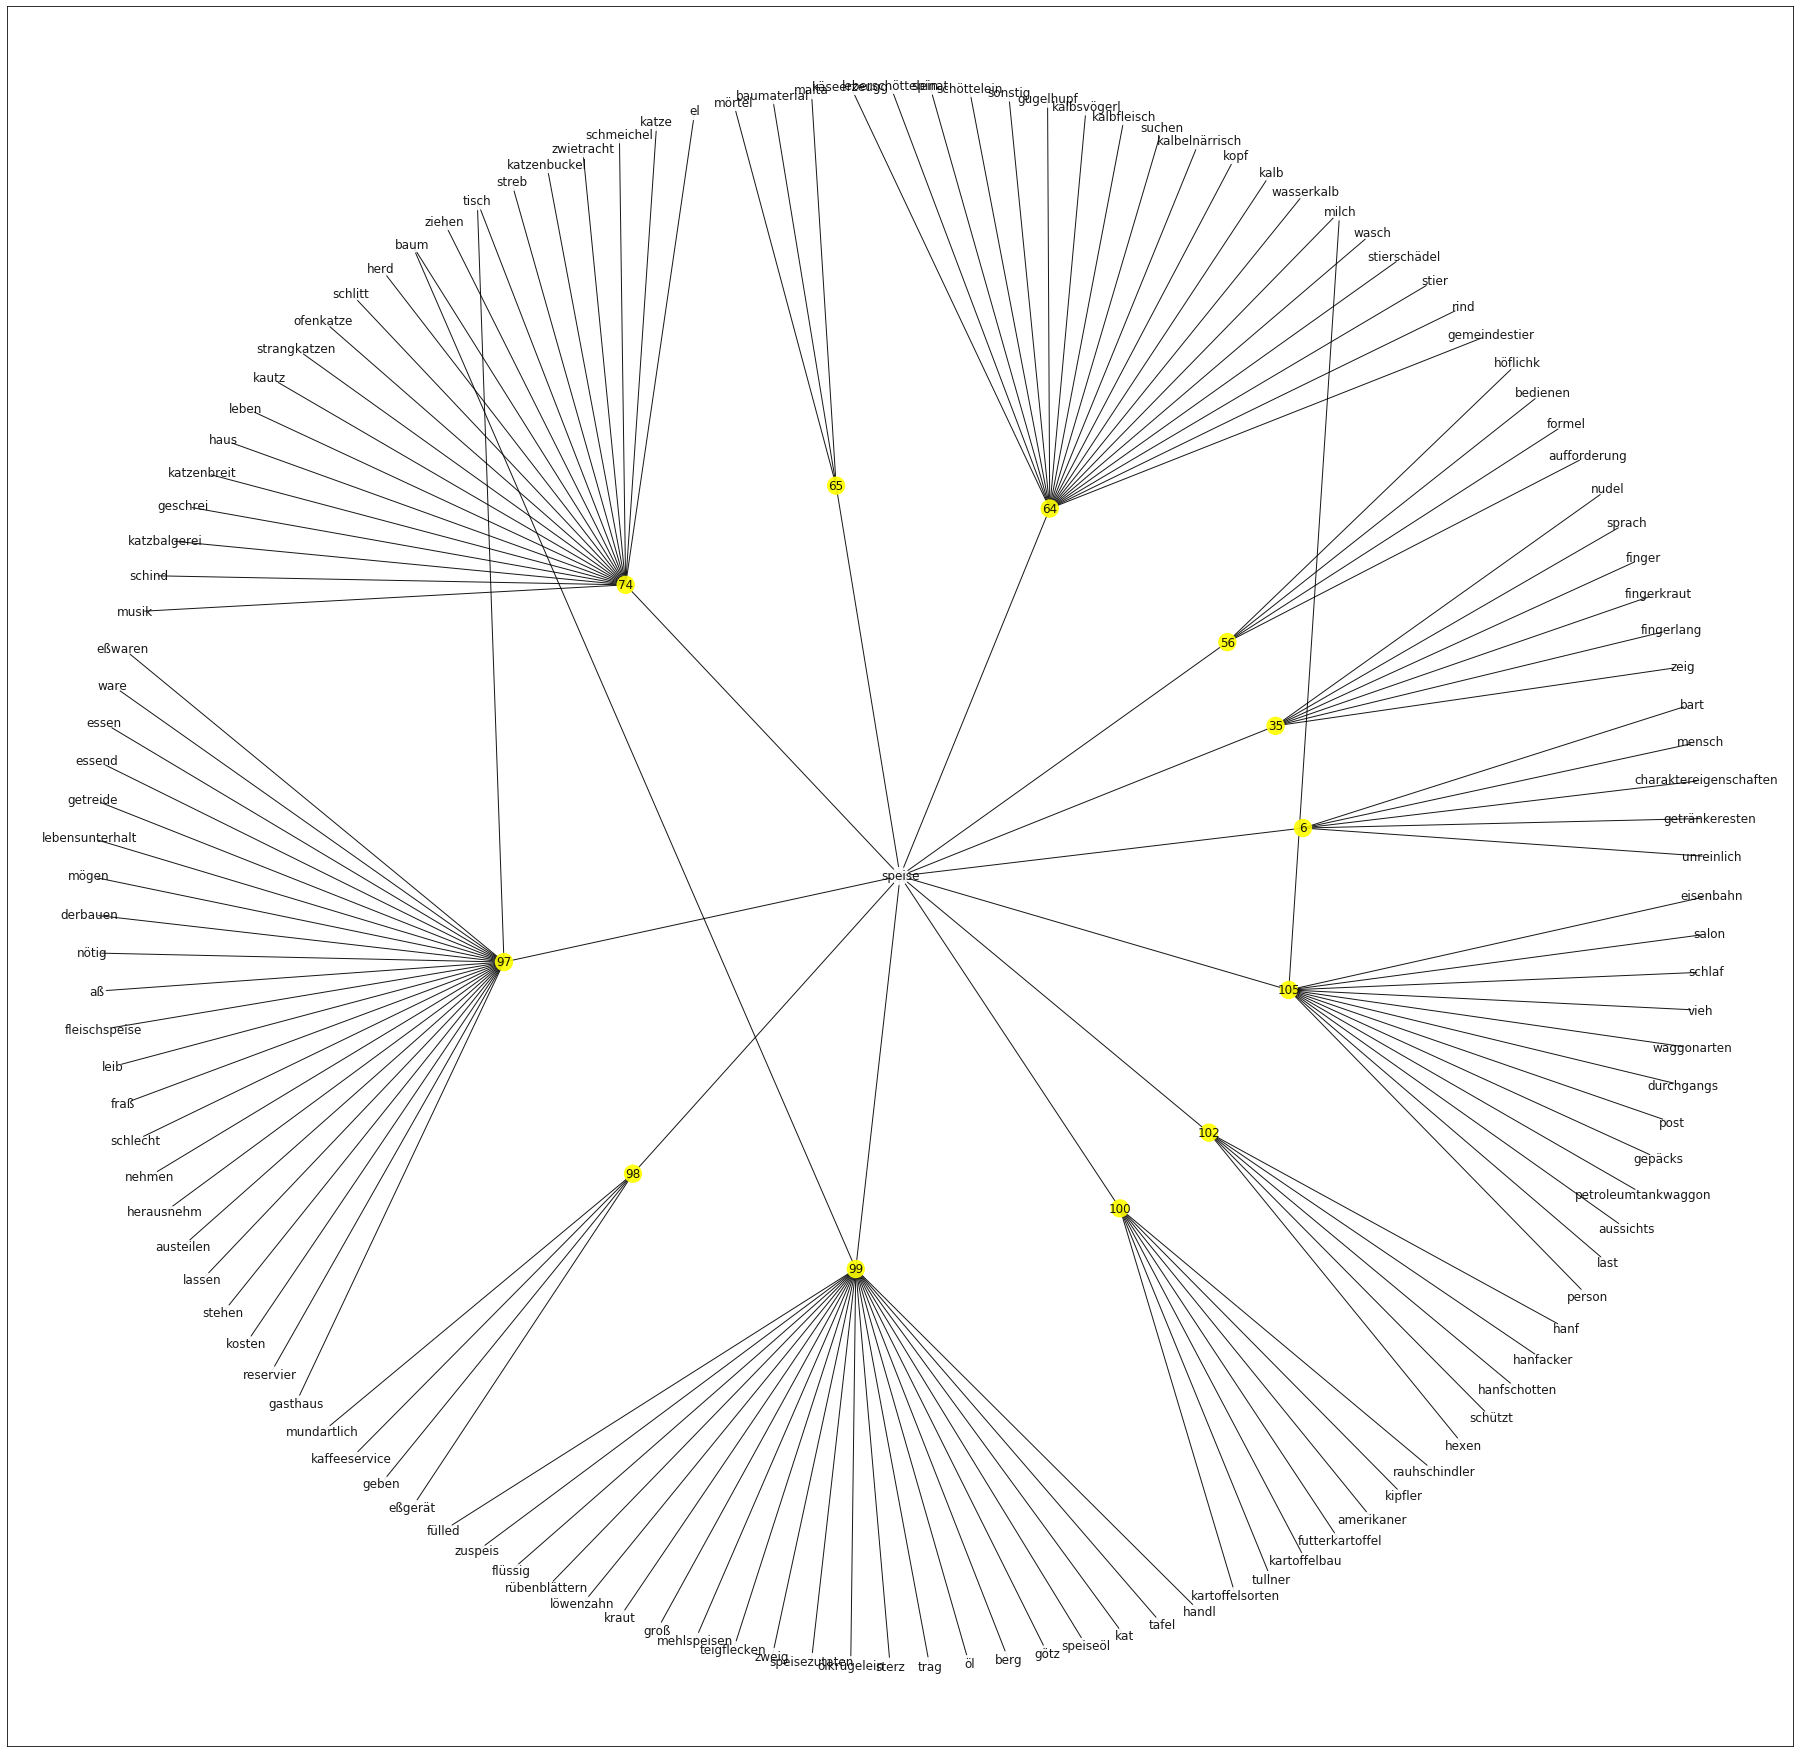

In [16]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )


#plt.show()


plt.savefig('./outputs/{}_frage.png'.format(cfilter), bbox_inches='tight')

### Topic Modeling with the concepts

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.

In [17]:
all_concepts = []
for entry in frage.semantic_words.values:
    all_concepts.append(entry)
    
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(all_concepts)
#dictionary.filter_extremes(no_below=1, no_above=0.9)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_concepts]

Running LDA Model

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [18]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
num_topics = 8

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50)

In [19]:
ldamodel.print_topics(num_topics=num_topics, num_words=20)
#ldamodel.show_topics(10)

[(0,
  '0.016*"teil" + 0.009*"holz" + 0.009*"körper" + 0.008*"feld" + 0.008*"wer" + 0.007*"wiese" + 0.007*"flachs" + 0.006*"gasthaus" + 0.006*"hanfarbeit" + 0.005*"wein" + 0.005*"schiffsteil" + 0.005*"obst" + 0.005*"kalt" + 0.004*"milch" + 0.004*"trinken" + 0.004*"be" + 0.004*"ausdrücken" + 0.004*"milchwirtsch" + 0.004*"boden" + 0.003*"geburt"'),
 (1,
  '0.019*"eisenbahn" + 0.015*"jagd" + 0.010*"vogel" + 0.008*"wild" + 0.008*"bierbereitg" + 0.008*"schneiderei" + 0.008*"fisch" + 0.006*"schwein" + 0.005*"wohnstube" + 0.005*"faßbinder" + 0.004*"ziege" + 0.004*"schön" + 0.004*"werkzeug" + 0.004*"leben" + 0.004*"tod" + 0.004*"gewehr" + 0.004*"gut" + 0.004*"kurz" + 0.003*"wind" + 0.003*"rücken"'),
 (2,
  '0.025*"körper" + 0.014*"waldbaum" + 0.010*"wild" + 0.008*"essen" + 0.007*"rind" + 0.007*"bier" + 0.005*"schlagen" + 0.005*"haar" + 0.005*"wagen" + 0.004*"bewegung" + 0.004*"stoß" + 0.004*"zuspeis" + 0.004*"arm" + 0.004*"tier" + 0.004*"ei" + 0.004*"schiffahrt" + 0.003*"küche" + 0.003*"mensch

In [20]:
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)
dic_topics = {num:words for num, words in topics_matrix}
df = pd.DataFrame(dic_topics)
df = df.reindex(sorted(df.columns), axis=1)
df.head(20)
#{num:words for num, words in topics_matrix}

0                           1  \
0           (teil, 0.015656957)    (eisenbahn, 0.019408138)   
1           (holz, 0.009268977)         (jagd, 0.014938227)   
2         (körper, 0.008658298)        (vogel, 0.009563332)   
3           (feld, 0.007925669)          (wild, 0.00831413)   
4           (wer, 0.0075480132)  (bierbereitg, 0.008274654)   
5          (wiese, 0.006884291)  (schneiderei, 0.008229165)   
6         (flachs, 0.006701855)        (fisch, 0.008219519)   
7      (gasthaus, 0.0056609013)      (schwein, 0.005837474)   
8    (hanfarbeit, 0.0055427854)    (wohnstube, 0.005325706)   
9           (wein, 0.005197525)   (faßbinder, 0.0050051454)   
10    (schiffsteil, 0.00513683)        (ziege, 0.004496448)   
11         (obst, 0.0048623825)        (schön, 0.004358392)   
12         (kalt, 0.0045752693)     (werkzeug, 0.004321768)   
13         (milch, 0.004466018)        (leben, 0.004266426)   
14       (trinken, 0.004398953)         (tod, 0.0042380528)   
15           (be, 0.0039891433)       (gewehr, 0.004122369)   
16   (ausdrücken, 0.0038710472)         (gut, 0.0036795929)   
17  (milchwirtsch, 0.003811638)        (kurz, 0.0035246632)   
18         (boden, 0.003721344)        (wind, 0.0034965344)   
19       (geburt, 0.0034982234)      (rücken, 0.0033736685)   

                             2                                 3  \
0        (körper, 0.024992973)            (sonstig, 0.011706226)   
1      (waldbaum, 0.014034915)          (werkzeuge, 0.008936643)   
2          (wild, 0.010059742)       (wasserbauten, 0.008199492)   
3        (essen, 0.0075617265)                (art, 0.007371602)   
4         (rind, 0.0067823906)         (hautkrankh, 0.006762252)   
5          (bier, 0.006780949)         (geschlecht, 0.006168321)   
6     (schlagen, 0.0049362653)        (verschieden, 0.006098403)   
7          (haar, 0.004861114)               (hand, 0.005963658)   
8          (wagen, 0.00452473)             (insekt, 0.005196166)   
9       (bewegung, 0.00427577)               (bau, 0.0049256817)   
10        (stoß, 0.0040102773)         (schlafraum, 0.004416861)   
11     (zuspeis, 0.0039576073)            (fenster, 0.004200779)   
12         (arm, 0.0039081136)         (mauerwerk, 0.0040067374)   
13         (tier, 0.003888556)           (eßgerät, 0.0039479355)   
14          (ei, 0.0036967297)            (knecht, 0.0036661476)   
15  (schiffahrt, 0.0036806446)      (maurerarbeit, 0.0034352036)   
16       (küche, 0.0034445818)        (besonderer, 0.0033613837)   
17      (mensch, 0.0031952662)       (rinderleben, 0.0032410524)   
18        (hund, 0.0031943345)         (schneider, 0.0031639247)   
19      (gemüse, 0.0030838577)  (frauenhandarbeit, 0.0031377743)   

                              4                              5  \
0           (mühle, 0.02589464)       (wagenteil, 0.010449077)   
1          (gerät, 0.010775494)        (gewässer, 0.010357563)   
2          (pferd, 0.009234342)          (brücke, 0.009081568)   
3           (baum, 0.008560371)           (gehen, 0.006642053)   
4           (post, 0.008542931)           (hals, 0.0058847493)   
5         (wetter, 0.007055688)    (frauenkleidg, 0.005287668)   
6         (feuer, 0.0069160247)       (hausdach, 0.0050295526)   
7        (schule, 0.0059821485)            (rad, 0.0049374397)   
8      (zugpferd, 0.0054739765)            (rot, 0.0039912416)   
9       (gespann, 0.0054739765)       (getreide, 0.0038628331)   
10       (wasser, 0.0052591097)    (leichenfeier, 0.003698555)   
11       (weinbau, 0.005192766)      (begräbnis, 0.0036451174)   
12    (säugetiere, 0.005020155)           (vieh, 0.0033206227)   
13           (wald, 0.00446233)  (wiesenpflanze, 0.0033159424)   
14         (feld, 0.0043578427)       (geschwür, 0.0032492408)   
15  (volksglaube, 0.0042952676)       (schießen, 0.0032424391)   
16         (mühl, 0.0040469137)            (erg, 0.0031977836)   
17    (zimmermann, 0.003730233)          (hühner, 0.003170765)   
18   (waldarbeit, 0.003

In [21]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, './outputs/lda.html')

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Using Word Embeddings

#### [trained model 1](https://devmount.github.io/GermanWordEmbeddings/#download)  

In [22]:
# get trained model, files without a suffix, .bin or .model are treated as binary files
trained_model1 = gensim.models.KeyedVectors.load_word2vec_format('../../nlp/German_Word2vec/german.model', binary=True)
# remove original vectors to free up memory
trained_model1.init_sims(replace=True)

Different [metrics](http://mkusner.github.io/publications/WMD.pdf)

In [23]:
print(trained_model1.similarity('kopf', 'blau'))
print(trained_model1.distance('kopf', 'blau'))

0.4494617
0.5505383014678955


In [24]:
words = ['Werkzeug', 'blau', 'rot', 'kopf', 'Gewerbe']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model1.most_similar(word, topn=40):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: Werkzeug
('Werkzeuge', 0.7832585573196411)
('Schraubenzieher', 0.7343912124633789)
('Schweissgeraet', 0.7339179515838623)
('Werkzeugen', 0.7225407361984253)
('Akkuschrauber', 0.7192946076393127)
('Werkzeugkoffer', 0.712235689163208)
('Stemmeisen', 0.7113085985183716)
('Bolzenschneider', 0.70192950963974)
('Brecheisen', 0.6978868246078491)
('Bohrmaschine', 0.6977435350418091)
('Spezialwerkzeug', 0.692556619644165)
('Winkelschleifer', 0.6898892521858215)
('Schraubendreher', 0.6841906309127808)
('Trennschleifer', 0.6812047958374023)
('Fahrradschloss', 0.6771385073661804)
('Akku-Schrauber', 0.6634371280670166)
('Handwerkszeug', 0.6628533005714417)
('Bohrmaschinen', 0.6614778637886047)
('Sackkarren', 0.6612217426300049)
('Minibagger', 0.659576952457428)
('Heckenschere', 0.6579685211181641)
('Tuerschloss', 0.6571305990219116)
('Arbeitsgeraet', 0.6566144227981567)
('Kettensaegen', 0.6561607718467712)
('Material', 0.6559394001960754)
('Schluesselbund', 0.6547551155090332)
('Werkzeugkast

In [25]:
list_words = ['blau', 'rot', 'feld', 'grün', 'gelb']
print(trained_model1.doesnt_match(list_words))

feld


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [26]:
for result in trained_model1.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rosa', 0.6545881032943726)
('orange', 0.6302927732467651)
('gruen', 0.619945764541626)
('rot', 0.619027316570282)
('Glitzer', 0.6155712604522705)
('lila', 0.6148803234100342)
('grau', 0.6142277717590332)
('pink', 0.6076772212982178)
('knallrot', 0.6024129390716553)
('knallige_Farben', 0.5976543426513672)


In [27]:
# function draw_words
# ... reduces dimensionality of vectors of given words either with PCA or with t-SNE and draws the words into a diagram
# @param word2vec model     to visualize vectors from
# @param list     words     list of word strings to visualize
# @param bool     pca       use PCA (True) or t-SNE (False) to reduce dimensionality 
# @param bool     alternate use different color and label align for every second word
# @param bool     arrows    use arrows to connect related words (items that are next to each other in list)
# @param float    x1        x axis range (from)
# @param float    x2        x axis range (to)
# @param float    y1        y axis range (from)
# @param float    y2        y axis range (to)
# @param string   title     for diagram

def draw_words(model, words, pca=False, alternate=True, arrows=True, x1=3, x2=3, y1=3, y2=3, title=''):
    # get vectors for given words from model
    vectors = [model.wv[word] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=0)
        vectors2d = tsne.fit_transform(vectors)

    # draw image
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])

    first = True # color alternation to divide given groups
    for point, word in zip(vectors2d , words):
        # plot points
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        # plot word annotations
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-large"
        )
        first = not first if alternate else first

    # draw arrows
    if arrows:
        for i in range(0, len(words)-1, 2):
            a = vectors2d[i][0] + 0.04
            b = vectors2d[i][1]
            c = vectors2d[i+1][0] - 0.04
            d = vectors2d[i+1][1]
            plt.arrow(a, b, c-a, d-b,
                shape='full',
                lw=0.1,
                edgecolor='#bbbbbb',
                facecolor='#bbbbbb',
                length_includes_head=True,
                head_width=0.08,
                width=0.01
            )

    # draw diagram title
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Cal

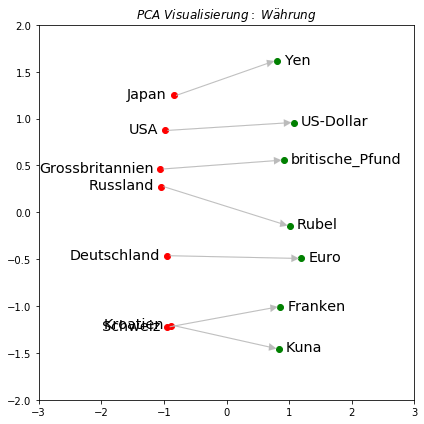

In [28]:
# plot currencies
words = ["Schweiz",
         "Franken",
         "Deutschland",
         "Euro",
         "Grossbritannien",
         "britische_Pfund",
         "Japan",
         "Yen",
         "Russland",
         "Rubel",
         "USA",
         "US-Dollar",
         "Kroatien",
         "Kuna"]

draw_words(trained_model1, words, True, True, True, -3, 3, -2, 2, r'$PCA\ Visualisierung:\ W\ddot{a}hrung$')

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attr

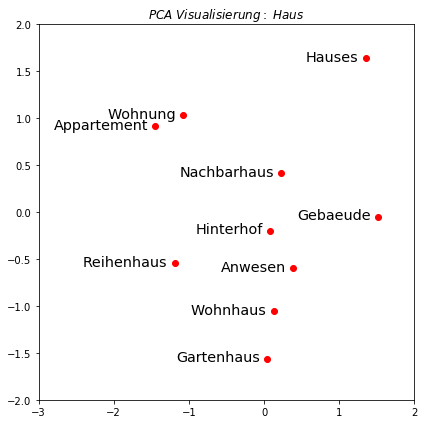

In [29]:
# plot related words to 'house'
matches = trained_model1.wv.most_similar(positive=["Haus"], negative=[], topn=10)
words = [match[0] for match in matches]
draw_words(trained_model1, words, True, False, False, -3, 2, -2, 2, r'$PCA\ Visualisierung:\ Haus$')

#### [trained model 2](https://deepset.ai/german-word-embeddings)

In [30]:
w2v_file = '../../nlp/Deepset_models/w2v/W2V_vectors2.txt'
trained_model2 = KeyedVectors.load_word2vec_format(w2v_file, binary=False, encoding="utf-8")

In [31]:
trained_model2.vectors.shape

(854776, 300)

In [32]:
print(trained_model2.similarity('kopf', 'blau'))
print(trained_model2.distance('kopf', 'blau'))

0.31584507
0.6841549277305603


In [33]:
words = ['blau', 'rot', 'kopf', 'gewerbe']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model2.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('rot', 0.8878530859947205)
('grün', 0.8801577687263489)
('gelb', 0.8124666213989258)
('schwarz', 0.7995022535324097)
('weiß', 0.7513998746871948)
('violett', 0.7186183333396912)
('dunkelblau', 0.7036298513412476)
('farben', 0.6818685531616211)
('silbern', 0.6753426194190979)
('blauen', 0.6669750213623047)
('grau', 0.6544827222824097)
('blauer', 0.652576744556427)
('gestreift', 0.6439394354820251)
('lila', 0.6385097503662109)
('dunkelrot', 0.6316858530044556)
('hellblau', 0.6249961853027344)
('schild', 0.6212359070777893)
('beige', 0.6211506724357605)
('türkis', 0.61705482006073)
('blaue', 0.6129087209701538)

word: rot
('blau', 0.8878530263900757)
('grün', 0.8219360709190369)
('gelb', 0.8039773106575012)
('schwarz', 0.7836544513702393)
('weiß', 0.7218809127807617)
('violett', 0.6870977282524109)
('dunkelblau', 0.6600711345672607)
('silbern', 0.6583701968193054)
('farben', 0.64675372838974)
('blauen', 0.642576277256012)
('grau', 0.636203408241272)
('blauer', 0.6272552013397

In [34]:
list_words = ['blau', 'rot', 'feld', 'grün', 'gelb']
print(trained_model2.doesnt_match(list_words))

feld


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [35]:
for result in trained_model2.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rot', 0.6391851305961609)
('grün', 0.6378831267356873)
('gelb', 0.6027040481567383)
('schwarz', 0.5865936279296875)
('lila', 0.5341690182685852)
('weiß', 0.5315088629722595)
('violett', 0.5308850407600403)
('blauen', 0.5186036229133606)
('blaue', 0.4993555545806885)
('silbern', 0.4934939742088318)


### Training our own model

In [36]:
sentences = []
for sentence in frage.semantic_words.values:
    sentences.append(sentence)

our_model = gensim.models.Word2Vec(sentences, min_count=1)

In [37]:
words = ['blau', 'rot', 'kopf']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in our_model.wv.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('heißen', 0.6910290718078613)
('ver', 0.6896626949310303)
('wer', 0.6836112141609192)
('teil', 0.6799972057342529)
('bauer', 0.6795907020568848)
('vogel', 0.6785189509391785)
('haus', 0.6775968670845032)
('nennen', 0.677577018737793)
('ähnlich', 0.677127480506897)
('name', 0.6744801998138428)
('gut', 0.6729016900062561)
('gehen', 0.6727060675621033)
('baum', 0.6721348762512207)
('pferd', 0.6715500354766846)
('groß', 0.6707885265350342)
('bräuche', 0.6701940894126892)
('form', 0.6687608957290649)
('weinbau', 0.6672758460044861)
('schneiderei', 0.6665210127830505)
('waldbaum', 0.6650208234786987)

word: rot
('gehen', 0.7936679124832153)
('wer', 0.7925474047660828)
('auge', 0.7909553050994873)
('baum', 0.7877382040023804)
('schneiderei', 0.7865560054779053)
('ähnlich', 0.7846904993057251)
('klein', 0.7837464809417725)
('heißen', 0.7825348377227783)
('gewerbe', 0.7786396741867065)
('kommen', 0.7761020660400391)
('besonderer', 0.775781512260437)
('form', 0.7748520374298096)
('s

In [38]:
# saving the model
our_model.wv.save_word2vec_format('./nlp/our_model.bin', binary=True)

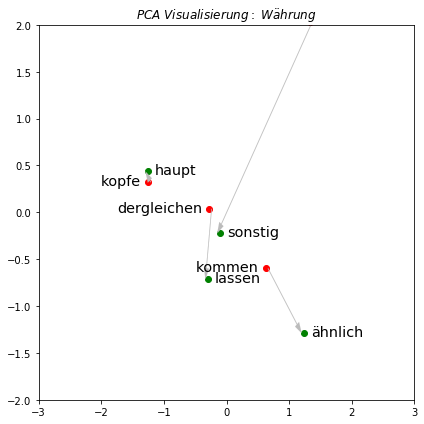

In [39]:
# plot currencies
words = ["kopfe",
         "haupt",
         "besonderer",
         "sonstig",
         "kommen",
         "ähnlich",
         #"Japan",
         #"Yen",
         #"Russland",
         #"Rubel",
         #"USA",
         #"US-Dollar",
         "dergleichen",
         "lassen",
        ]

draw_words(our_model, words, True, True, True, -3, 3, -2, 2, r'$PCA\ Visualisierung:\ W\ddot{a}hrung$');

In [40]:
for result in our_model.most_similar(positive=['werkzeug'], topn=40):
    print(result)

('waldbaum', 0.8273497819900513)
('heißen', 0.812564492225647)
('gewerbe', 0.8113102912902832)
('reden', 0.8099004030227661)
('dergleichen', 0.809308648109436)
('ähnlich', 0.8072977662086487)
('groß', 0.8066095113754272)
('sei', 0.8016433119773865)
('gehen', 0.8001686334609985)
('besonderer', 0.7999058961868286)
('baum', 0.7992882132530212)
('kommen', 0.7981661558151245)
('verwendung', 0.7981647253036499)
('bauer', 0.7981365323066711)
('vogel', 0.7978683114051819)
('teil', 0.7977128028869629)
('haut', 0.7976664304733276)
('feld', 0.7960242033004761)
('wer', 0.7920198440551758)
('wagenteil', 0.7919455170631409)
('name', 0.7890647053718567)
('schneiderei', 0.7886749505996704)
('dreschen', 0.7885019183158875)
('form', 0.7880361676216125)
('mühle', 0.7868722677230835)
('wann', 0.7866755723953247)
('kind', 0.7859063148498535)
('volksglaube', 0.7856326103210449)
('schiffahrt', 0.7855396270751953)
('art', 0.7840898036956787)
('wetter', 0.7827352285385132)
('wort', 0.7811494469642639)
('holz',

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


#### Expanding a graph with similar words

In [41]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [42]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        for w in our_model.wv.most_similar(concept, topn=5):
            G.add_node(w[0], color='white')
            G.add_edge(concept, w[0], length = 10)        
        
for questionnaire in filtered.fragebogen_num:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_num'], length = 10)

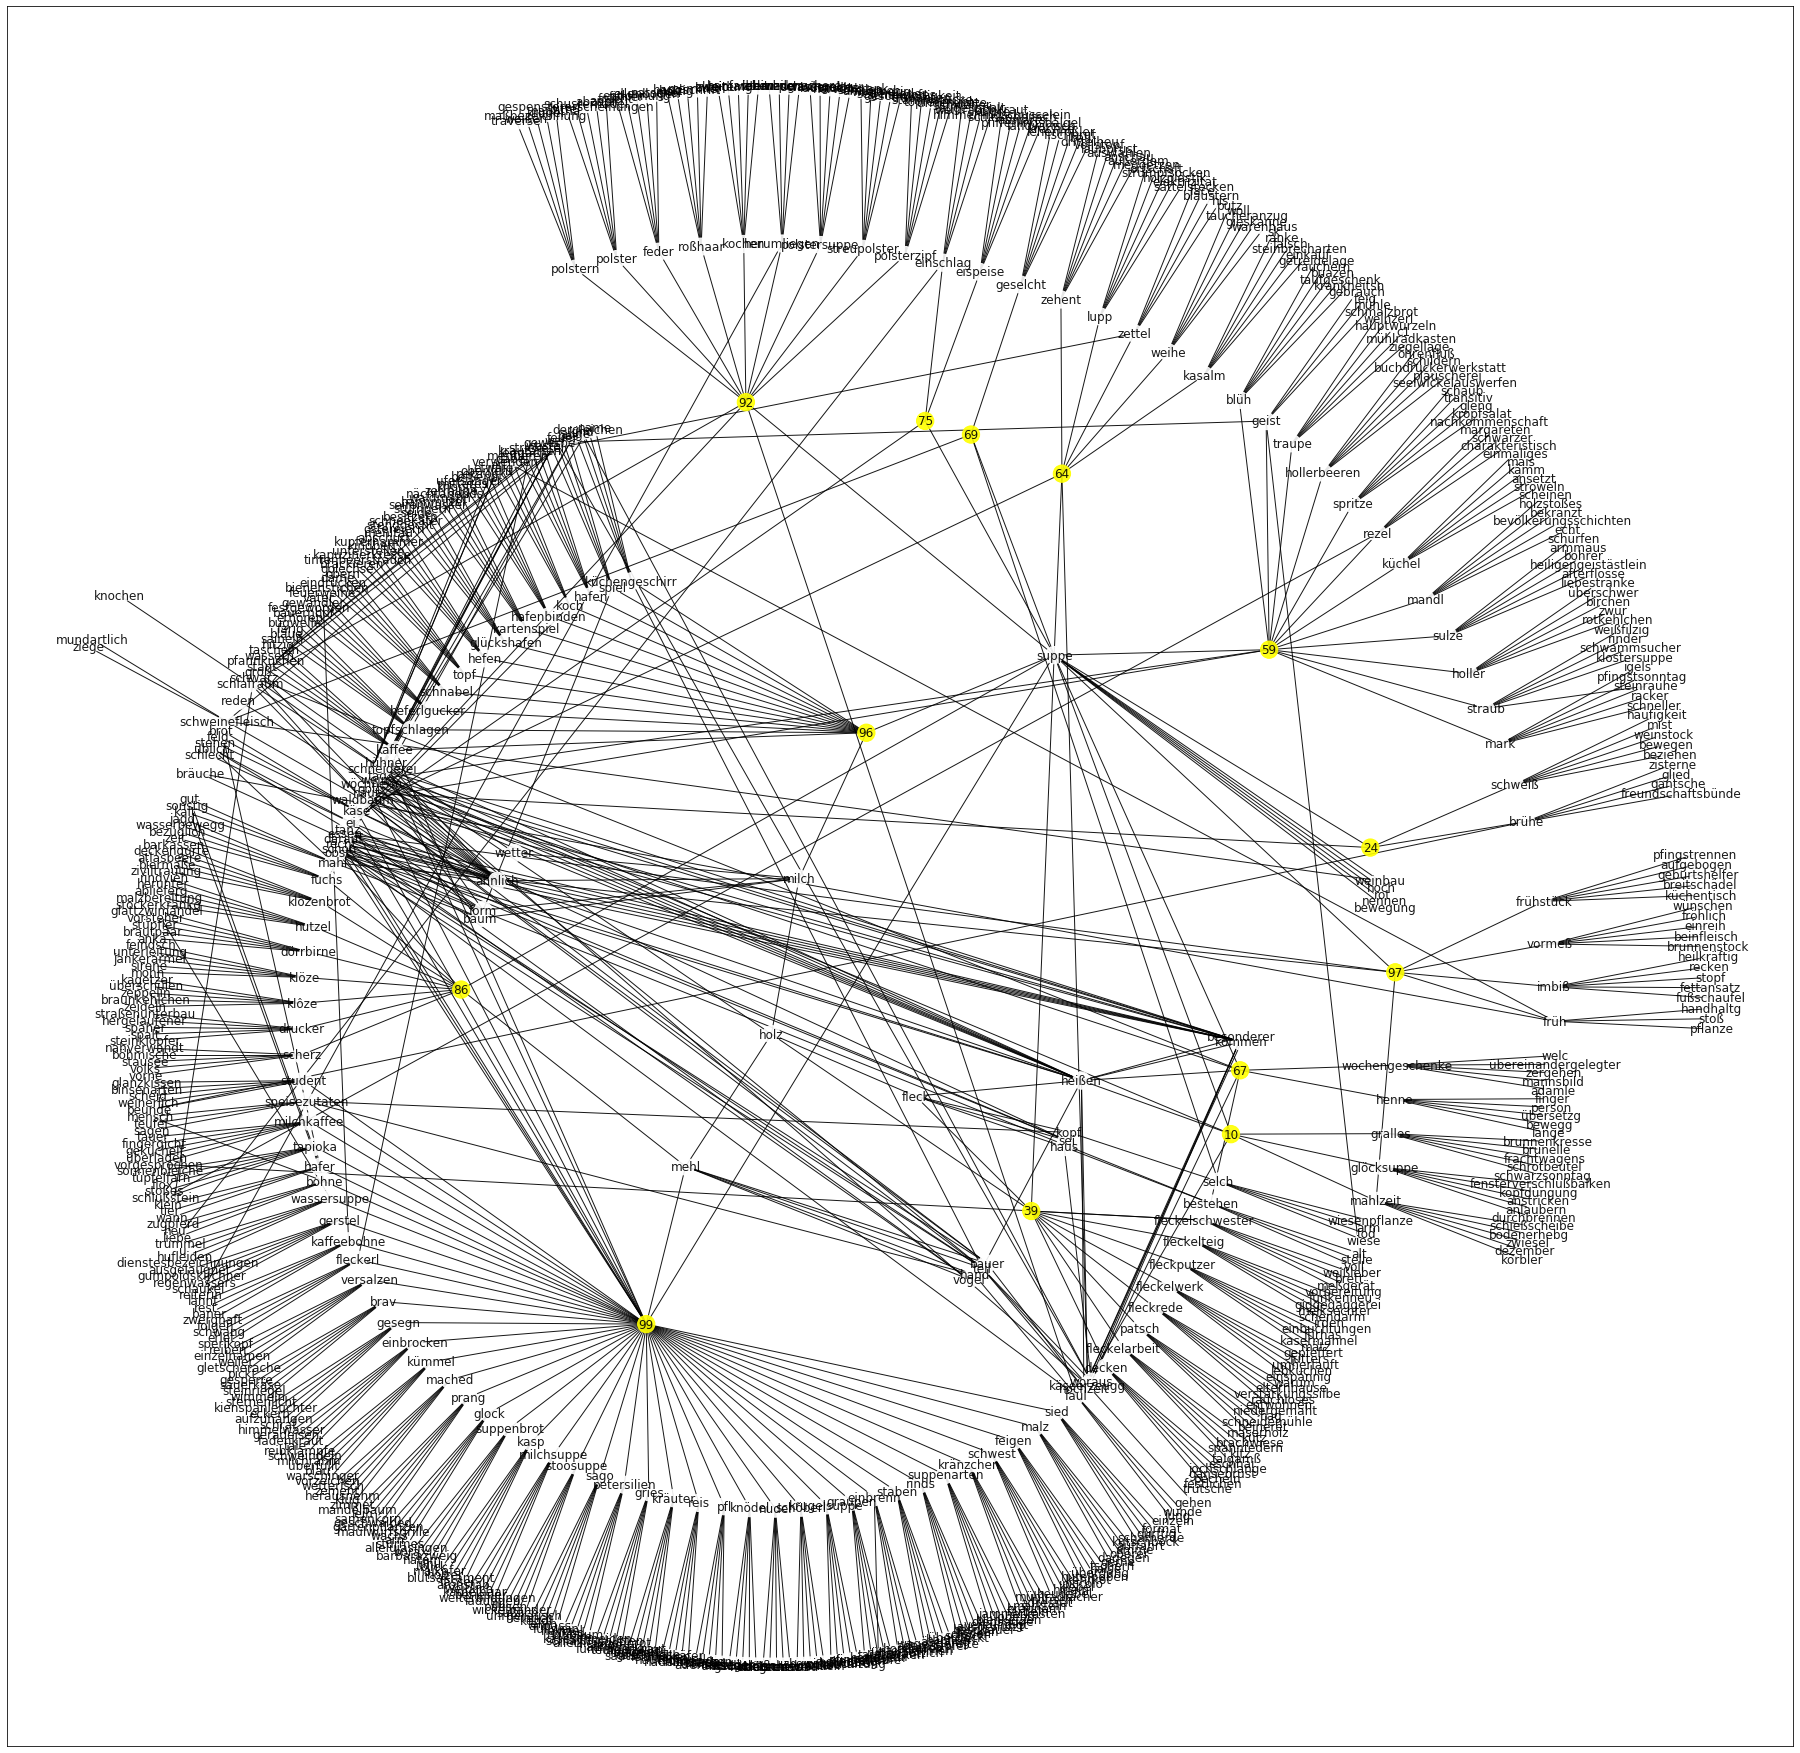

In [43]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

#plt.show()

plt.savefig('./outputs/{}_frage_plus_similar.png'.format(cfilter), bbox_inches='tight')

### Using [GermaNet](http://www.sfs.uni-tuebingen.de/GermaNet/) with [PyGermanet](https://pypi.org/project/pygermanet/)

In [44]:
#https://nlpforhackers.io/starting-wordnet/

from pygermanet import load_germanet, Synset
from scipy.stats.stats import pearsonr

In [45]:
from pygermanet import load_germanet
gn = load_germanet()

In [46]:
#word = 'Suppe'
#word = 'falb'
word = 'Kopf'

lem = gn.lemmatise(word)[0]
print("concept: {}, lemma: {} ".format(word, lem))
print()
syn = gn.synsets(lem)
if not syn:
    syn = gn.synsets(lem.title()) #[0]
else:
    syn = gn.synsets(lem) #[0]
for s in syn:
    print("synset: ", s)
    print()
    for lemma in s.lemmas:
        print('\t- {}'.format(lemma.orthForm))
    print()    
    for hypo in s.hyponyms:
        print('\thyponym: {}'.format(hypo))
    print()
    for hyper in s.hypernyms:
        print('\thypernym: {}'.format(hyper))
        print()
    print('\tgeneric class: {}'.format(s.gn_class))
    print()
print()

concept: Kopf, lemma: Kopf 

synset:  Synset(Birne.n.1)

	- Birne
	- Schädel
	- Kopf
	- Haupt
	- Rübe

	hyponym: Synset(Menschenkopf.n.1)
	hyponym: Synset(Grind.n.3)
	hyponym: Synset(Männerkopf.n.1)
	hyponym: Synset(Tierkopf.n.1)
	hyponym: Synset(Krauskopf.n.1)
	hyponym: Synset(Engelskopf.n.1)
	hyponym: Synset(Köpfchen.n.1)
	hyponym: Synset(Charakterkopf.n.1)

	hypernym: Synset(Körperteil.n.1)

	generic class: Koerper

synset:  Synset(Kopf.n.2)

	- Kopf


	hypernym: Synset(Einzelindividuum.n.1)

	generic class: Mensch

synset:  Synset(Kopf.n.3)

	- Kopf
	- Anfangsteil


	hypernym: Synset(Bestandteil.n.1)

	generic class: Artefakt

synset:  Synset(Kopf.n.4)

	- Kopf


	hypernym: Synset(Silbenteil.n.1)

	generic class: Kommunikation

synset:  Synset(Kopf.n.6)

	- Kopf


	hypernym: Synset(nichtdefinite Längeneinheit.n.1)

	generic class: Menge

synset:  Synset(Kopf.n.7)

	- Kopf
	- Haupt

	hyponym: Synset(Hauptperson.n.1)
	hyponym: Synset(Familienhaupt.n.1)
	hyponym: Synset(Oberhaupt.n.1)

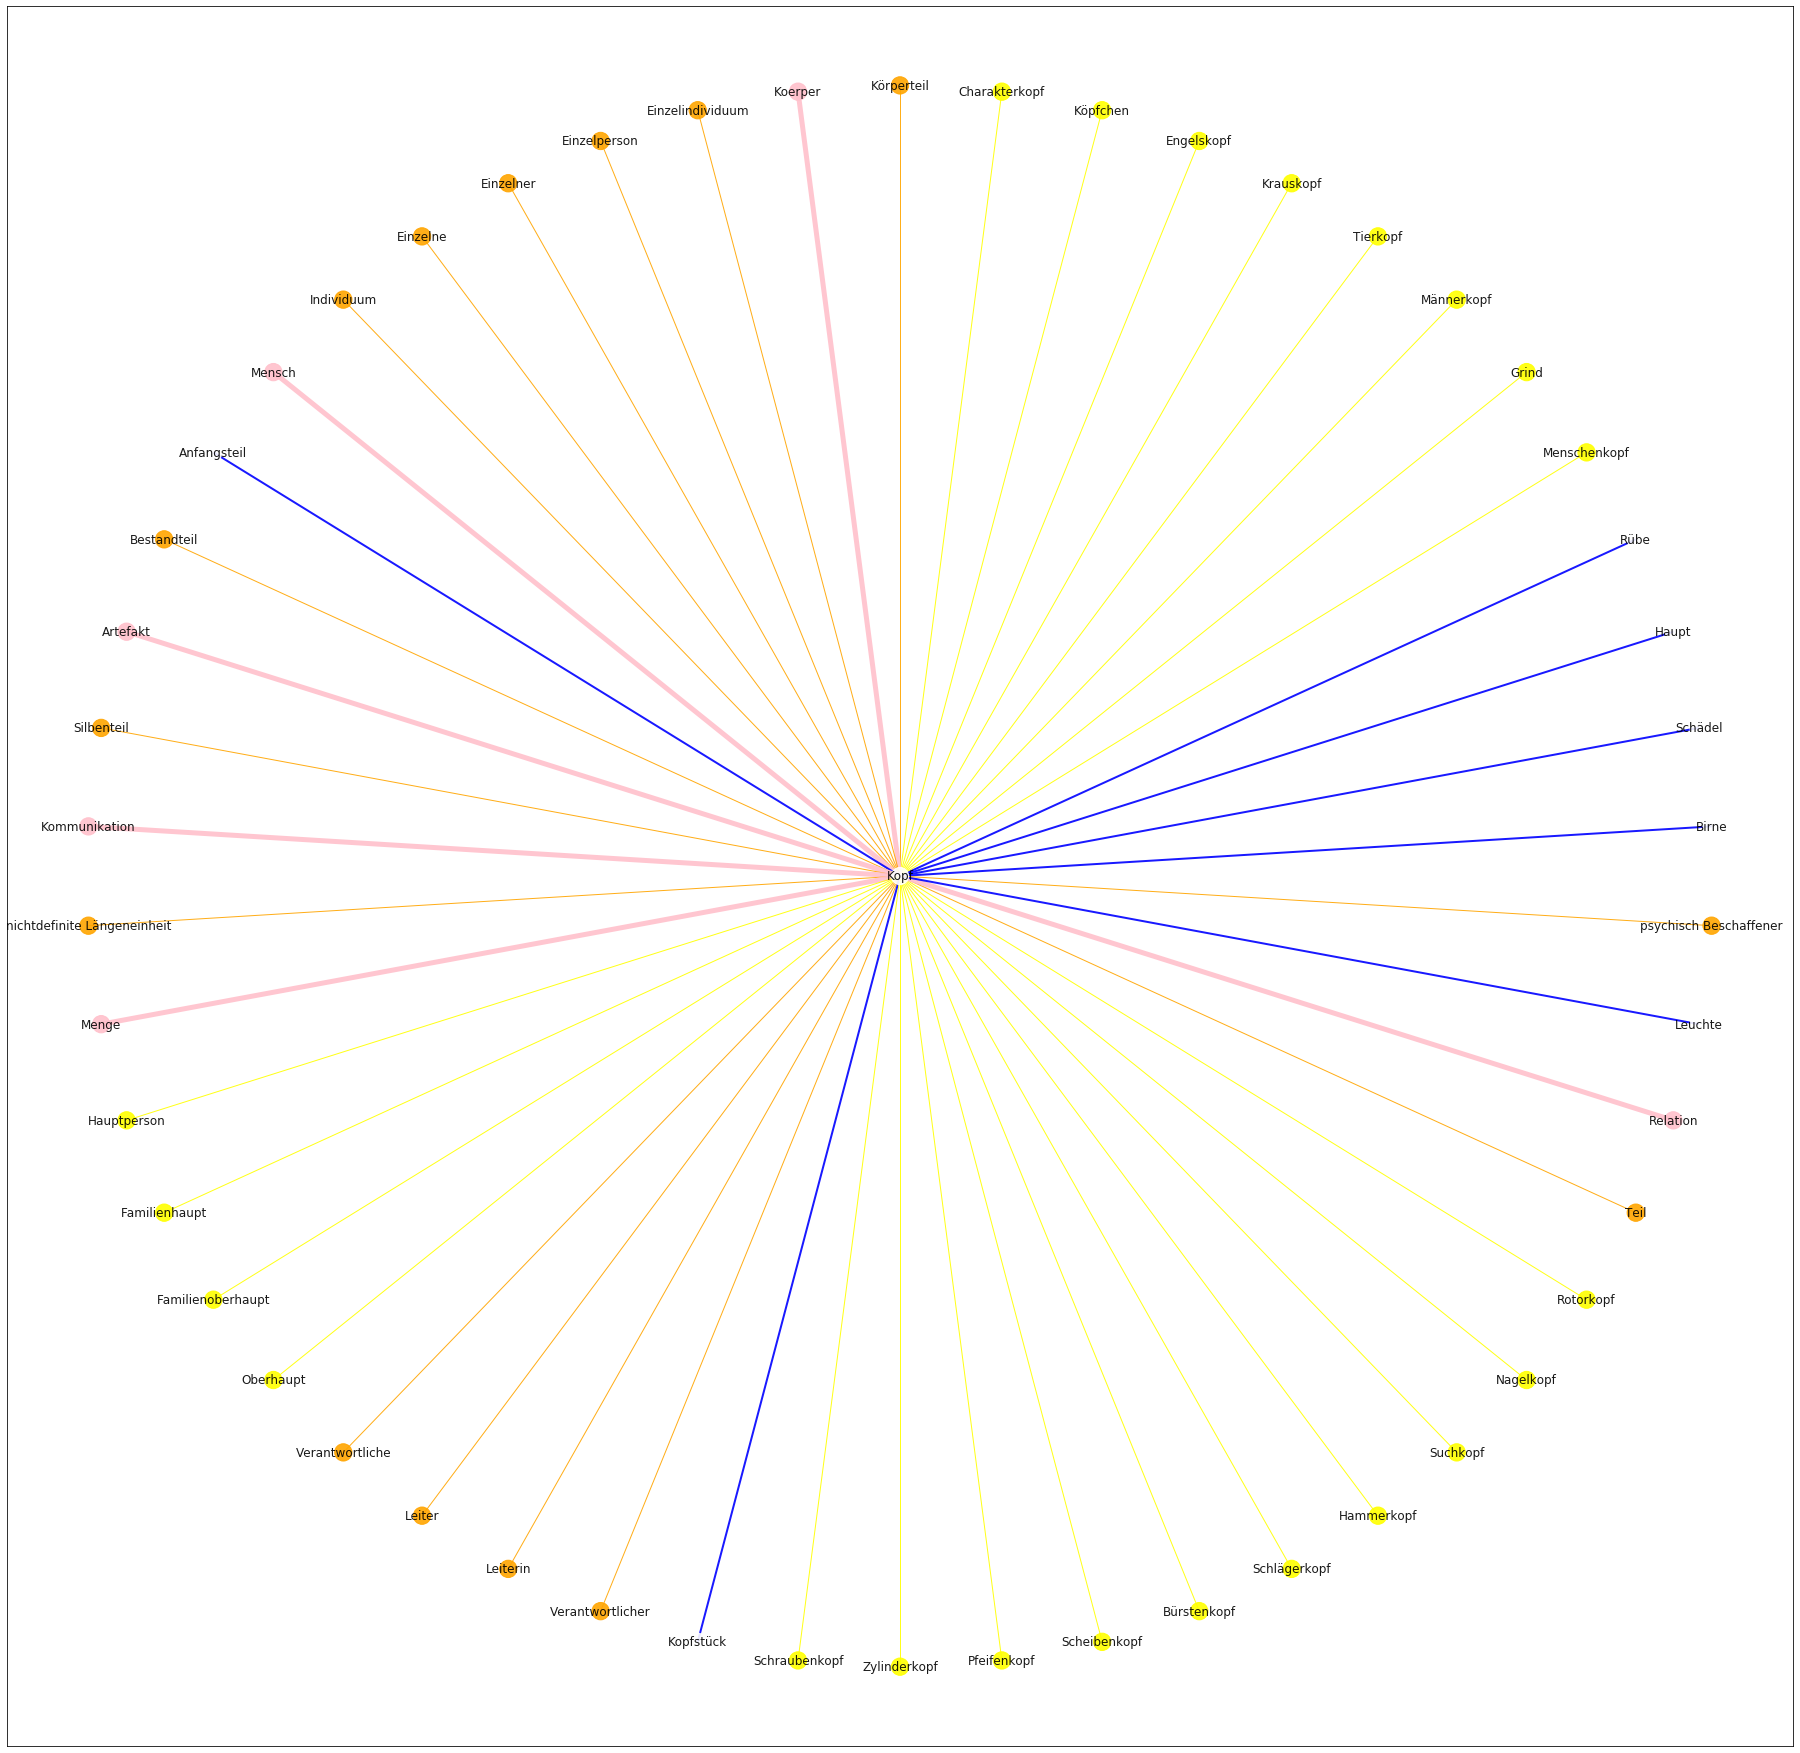

In [47]:
#word = 'Suppe'
#word = 'falb'
word = 'Kopf'

G = nx.Graph()

lem = gn.lemmatise(word)[0]
G.add_node(lem, color='white')

syn = gn.synsets(lem)
if not syn:
    syn = gn.synsets(lem.title()) #[0]
else:
    syn = gn.synsets(lem) #[0]

for s in syn:
    #print("synset: ", s)
    for lemma in s.lemmas:
        #print('\t- {}'.format(lemma.orthForm))
        G.add_node(lemma.orthForm, color='white')
        G.add_edge(lem, lemma.orthForm, color='blue', weight=2, length = 5)        
    for hypo in s.hyponyms:
        #print('\thyponym: {}'.format(hypo))
        for lemma in hypo.lemmas:
            #print('\t- {}'.format(lemma.orthForm))
            G.add_node(lemma.orthForm, color='yellow')
            G.add_edge(lem, lemma.orthForm, color='yellow', weight=1,length = 10)   
    for hyper in s.hypernyms:
        #print('\thypernym: {}'.format(hyper))
        for lemma in hyper.lemmas:
            #print('\t- {}'.format(lemma.orthForm))
            G.add_node(lemma.orthForm, color='orange')
            G.add_edge(lem, lemma.orthForm, color='orange', weight=1, length = 10)   
    #print('\tgeneric class: {}'.format(s.gn_class))
    G.add_node(s.gn_class, color='pink')
    G.add_edge(lem, s.gn_class, color='pink', weight=5, length = 2)
   
plt.figure(figsize=(32,32))
pos = graphviz_layout(G, prog='twopi', args='')

nx.draw_networkx(G, 
                 pos,
                 #edges=G.edges()
                 width=[G[u][v]['weight'] for u,v in G.edges()],
                 #width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 edge_color=nx.get_edge_attributes(G,'color').values(), #[G[u][v]['color'] for u,v in G.edges()]
                 #edge_cmap=plt.cm.Blues,
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

plt.savefig('./outputs/{}_germanet1.png'.format(word), bbox_inches='tight')

Building a Graph for the whole collection

In [48]:
G = nx.Graph()

for concept_list in frage.semantic_words:
    for concept in concept_list:
        lem = gn.lemmatise(concept)[0]
        G.add_node(lem, color='white', label='concept')
        syn = gn.synsets(lem)
        if not syn:
            syn = gn.synsets(lem.title()) #[0]
        else:
            syn = gn.synsets(lem) #[0]
        for s in syn:
            for hypo in s.hyponyms:
                for lemma in hypo.lemmas:
                    G.add_node(lemma.orthForm, color='yellow', label='hypo')
                    G.add_edge(lem, lemma.orthForm, color='yellow', weight=1,length = 10)
            for hyper in s.hypernyms:
                for lemma in hyper.lemmas:
                    G.add_node(lemma.orthForm, color='orange', label='hyper')
                    G.add_edge(lem, lemma.orthForm, color='orange', weight=1, length = 10)
            G.add_node(s.gn_class, color='pink', label='gn_class')
            G.add_edge(lem, s.gn_class, length = 10)

Finding the general classes

In [49]:
nodes_gclasses = [x for x,y in G.nodes(data=True) if y['label']=='gn_class']
nodes_gclasses

['Koerper',
 'Mensch',
 'Artefakt',
 'Kommunikation',
 'Menge',
 'Relation',
 'Zeit',
 'Allgemein',
 'Gefuehl',
 'Konkurrenz',
 'Kognition',
 'Gesellschaft',
 'Lokation',
 'Besitz',
 'Veraenderung',
 'Schoepfung',
 'Substanz',
 'Verhalten',
 'privativ',
 'Ort',
 'Kontakt',
 'Verbrauch',
 'natPhaenomen',
 'Perzeption',
 'Koerperfunktion',
 'Attribut',
 'Nahrung',
 'Pflanze',
 'Tier',
 'Geschehen',
 'Gruppe',
 'Form',
 'Bewegung',
 'Geist',
 'Pertonym',
 'natGegenstand',
 'Tops',
 'Motiv']

Building a graph for one general class

In [50]:
#https://stackoverflow.com/questions/45350222/select-nodes-and-edges-form-networkx-graph-with-attributes
word = 'natPhaenomen'
neighbors = list(nx.neighbors(G,word))
neighbors.append(word)
Gfilter = G.subgraph(neighbors)
len(Gfilter)

303

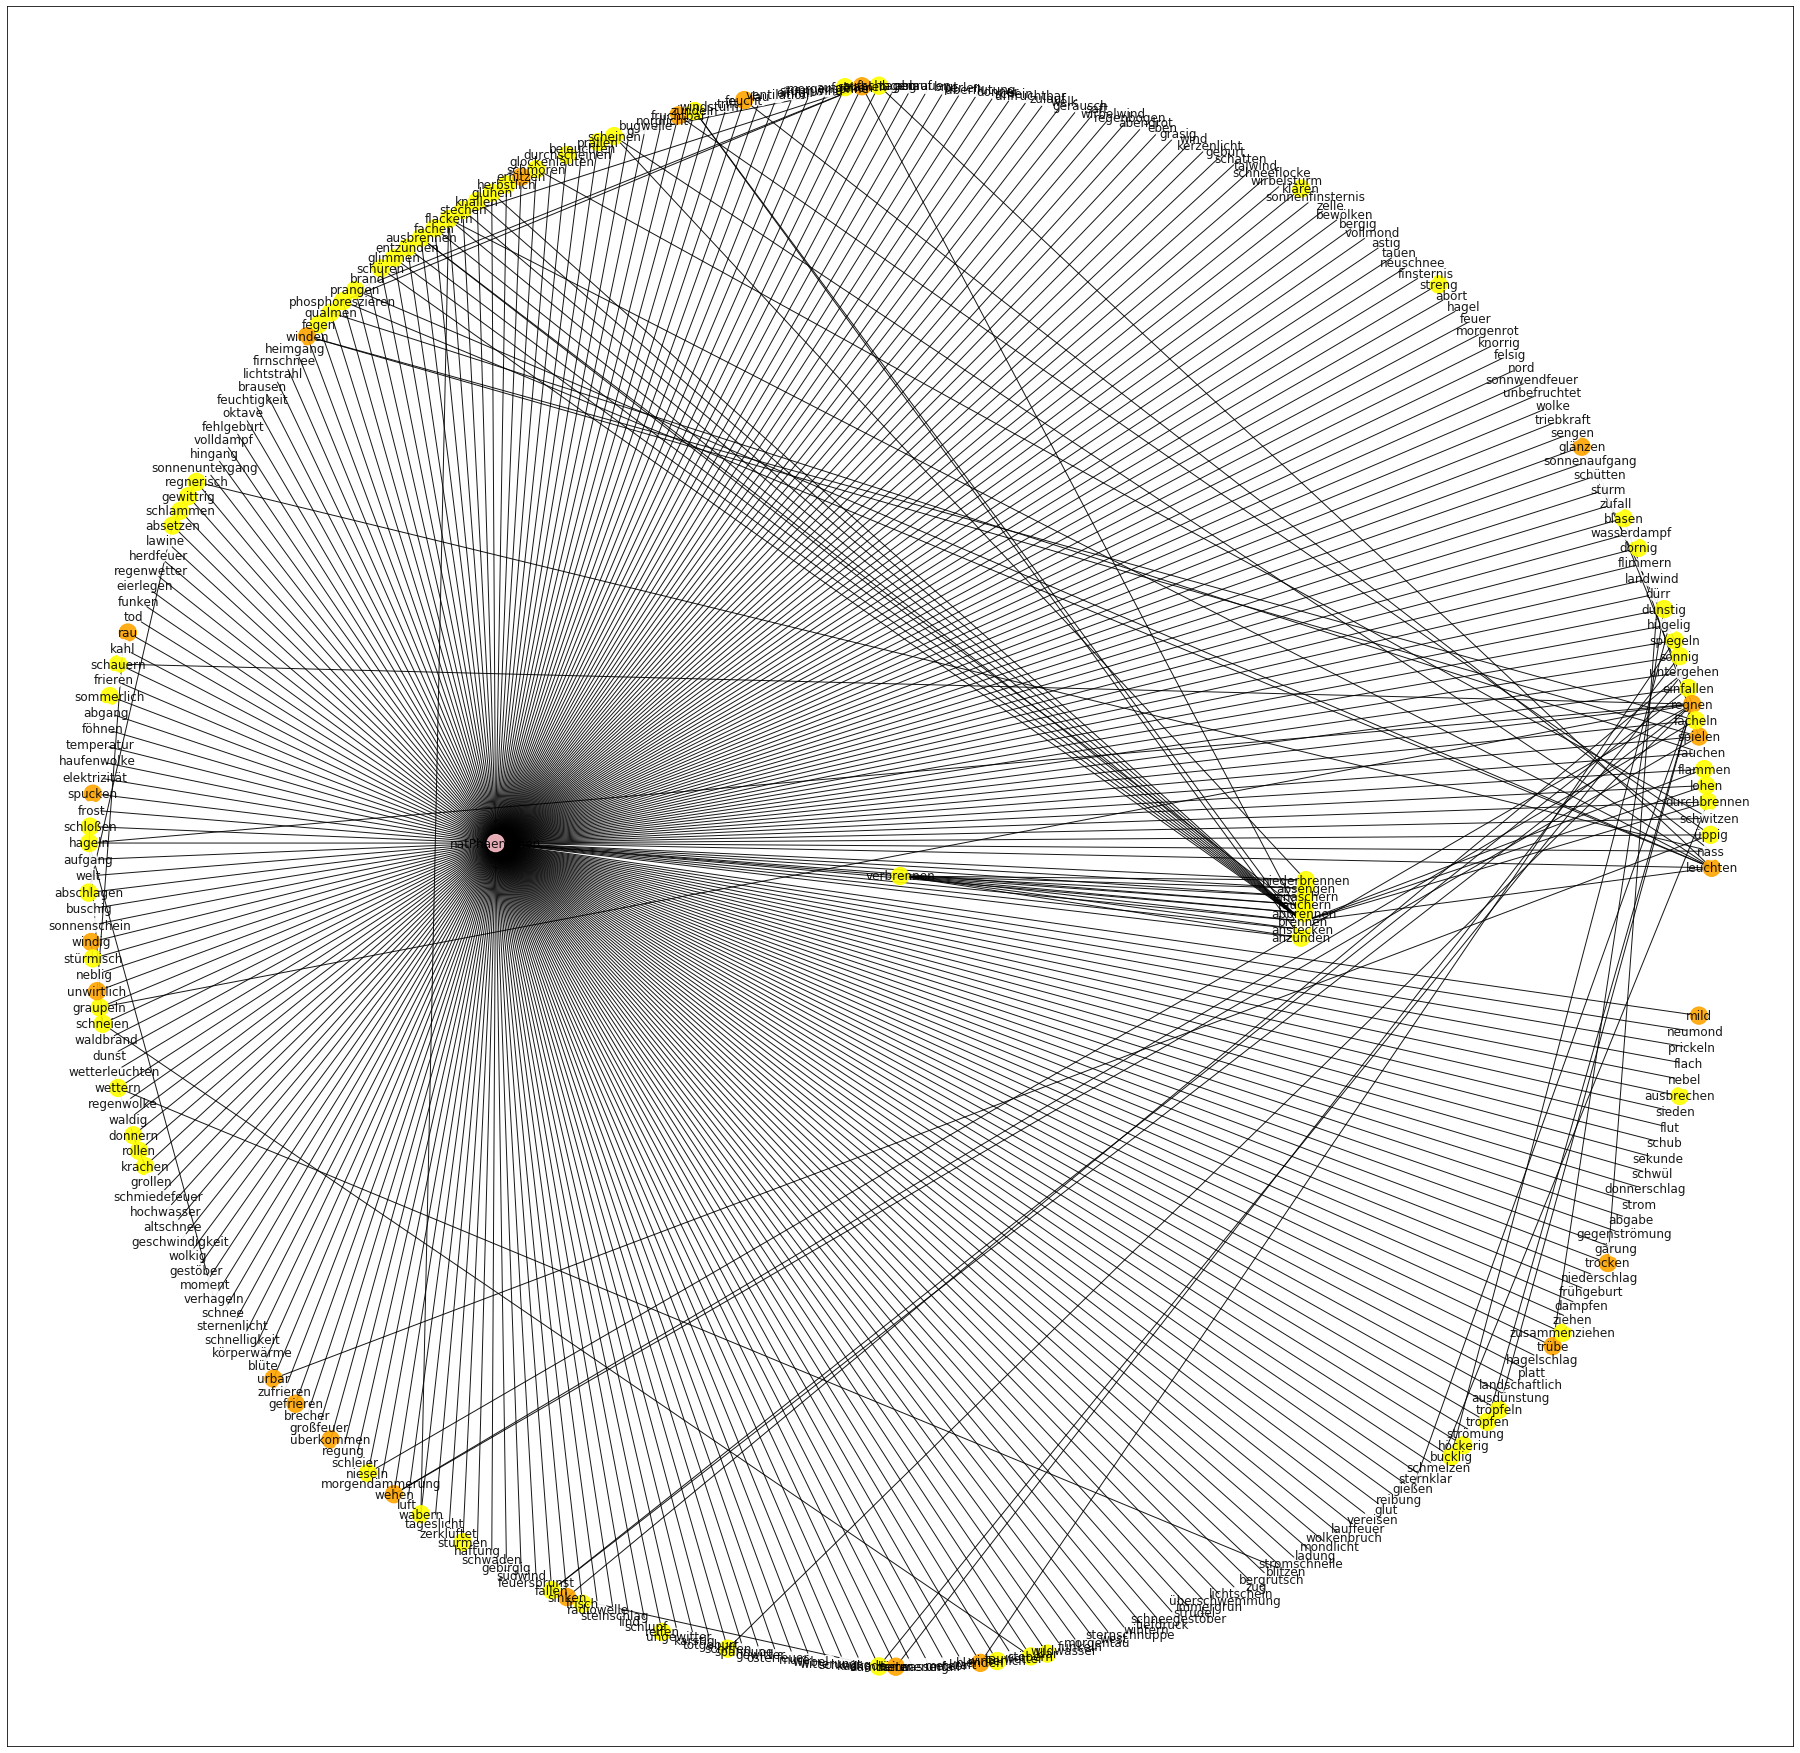

In [51]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(Gfilter)
#pos = graphviz_layout(Gfilter)
pos = graphviz_layout(Gfilter, prog='twopi', args='')


nx.draw_networkx(Gfilter, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(Gfilter,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

#plt.show()

plt.savefig('./outputs/{}_germanet2.png'.format(word), bbox_inches='tight')